<b>Pclass</b> is the Ticket-class: first (1), second (2), and third (3) class tickets were used. This is an ordinal integer feature.<br>
<b>Name</b> is the name of the passenger. <br>
<b>Sex</b> is an indicator whether the passenger was female or male. This is a categorical text string feature.<br>
<b>Age</b> is the integer age of the passenger.<br>
<b>SibSp</b> is an ordinal integer feature describing the number of siblings or spouses travelling with each passenger.<br>
<b>Parch</b> is an ordinal integer features that gives the number of parents or children travelling with each passenger.<br>
<b>Ticket</b> is a character string of variable length that gives the ticket number.<br>
<b>Fare</b> is a float feature showing how much each passenger paid for their rather memorable journey.<br>
<b>Cabin</b> gives the cabin number of each passenger. There are NaN in this column. This is another string feature.<br>
<b>Embarked</b> shows the port of embarkation as a categorical character value.<br>

<b>Resumo:</b><br>
<b>Wrangling Data</b><br>
Criação da feature Title a partir da feature Name<br>
Fillna de Age com Mediana de Título<br>
Fillna de Embarked com 'S' : Maioria da 1a Classe<br>
Feat Cabin com 1a letra, Null com 'X'<br>
Fillna de Fare com mediana de grupo selecionado<br>
Dataset drop PassengerId, Name, Ticket, Title<br>
get_dummies de Pclass, Sex, Cabin, Embarked : One hot encoding<br>
Nada feito com Outliers<br>
Criação de feat FamilySize pela soma de SibSp + Parch + 1<br>
Nada Normalizado<br>
<p>
<b>Modelagem</b><br>
Kfolds = 5<br>
Cross Validation sem Leak<br>
CV com modelos SVC, DecisionTree, AdaBoost, RandomForest, ExtraTrees, GradientBoosting, MultipleLayerPerceptron, KNeighboors, LogisticRegression, LinearDiscriminantAnalysis, XGBClassifier, LGBMClassifier<br>
GridSearchCV em XGBClassifier, GradientBoostingClassifier, LogisticRegression, LinearDiscriminantAnalysis, LGBMClassifier, RandomForestClassifier<br>
Learning Curves<br>
Feature Importance<br>
Ensemble modeling : RandomForest, GradientBoosting, LGBM, XGB<br>
VotingClassifier<br>

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import timeit
import missingno as msno
import warnings
import time

In [2]:
# VARIÁVEIS
pd.options.display.max_seq_items = 2000
pd.options.display.max_rows = 4000
matplotlib.style.use('ggplot') # Look Pretty
sns.set_style("whitegrid")
warnings.filterwarnings(action="ignore")
%matplotlib inline

In [3]:
path = r'D:\DATA_SCIENCE\Kaggle\Titanic'

In [4]:
train  = pd.read_csv(path + '\\Titanic_train.csv')
test = pd.read_csv(path + '\\Titanic_test.csv')

In [5]:
id_test = test['PassengerId']
train_size = len(train)
test_size = len(test)
print('Train shape = ', train.shape, ' | Test shape = ', test.shape)

Train shape =  (891, 12)  | Test shape =  (418, 11)


<h2>Identifing Data

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
def get_meta(df):
    data = []
    for col in df.columns:

        dtype  = df[col].dtype
        count  = df[col].count()
        unique = (len(df[col].unique()))-(pd.isnull(df[col]).any())
        qtd_na = df[col].isnull().sum()
        exemp  = df[col].unique()
        
        if df[col].dtype == 'object': var = 'object'
        else: var    = df[col].max() - df[col].min()
            
        if df[col].dtype == 'object': mean = 'object'
        else: mean    = df[col].mean()
            
        if df[col].dtype == 'object': median = 'object'
        else: median  = df[col].median()

        col_dict = {
            'column'   : col,
            'dtype'    : dtype,
            'count'    : count,
            'unique'   : unique,
            'mean'     : mean,
            'median'   : median,
            'qtd_Null' : qtd_na,
            'variac'   : var,
            'exemp'    : exemp
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=['column', 'dtype', 'count', 'unique', 'mean', 'median', 'qtd_Null', 'variac', 'exemp'])
    meta.set_index('column', inplace=True)
    return meta

In [8]:
def stacked_bar_per_class(col, dropna=True):
    Pclass1 = dataset[dataset['Pclass']==1][col].value_counts(dropna=dropna)
    Pclass2 = dataset[dataset['Pclass']==2][col].value_counts(dropna=dropna)
    Pclass3 = dataset[dataset['Pclass']==3][col].value_counts(dropna=dropna)
    df_Pclass = pd.DataFrame([Pclass1, Pclass2, Pclass3])
    df_Pclass.index = ['1st Class', '2nd Class', '3rd Class']
    df_Pclass.plot(kind='bar', stacked=True, figsize=(10,5))
    plt.show()

<h2>Wrangling Data

In [9]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat([train, test], axis=0).reset_index(drop=True)

In [10]:
get_meta(dataset)

,dtype,count,unique,mean,median,qtd_Null,variac,exemp
column,,,,,,,,
Age,float64,1046,98,29.8811,28,263,79.83,"[22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,..."
Cabin,object,295,186,object,object,1014,object,"[nan, C85, C123, E46, G6, C103, D56, A6, C23 C..."
Embarked,object,1307,3,object,object,2,object,"[S, C, Q, nan]"
Fare,float64,1308,281,33.2955,14.4542,1,512.329,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51...."
Name,object,1309,1307,object,object,0,object,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
Parch,int64,1309,8,0.385027,0,0,9,"[0, 1, 2, 5, 3, 4, 6, 9]"
PassengerId,int64,1309,1309,655,655,0,1308,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
Pclass,int64,1309,3,2.29488,3,0,2,"[3, 1, 2]"
Sex,object,1309,2,object,object,0,object,"[male, female]"


<b>Identifing NaNs

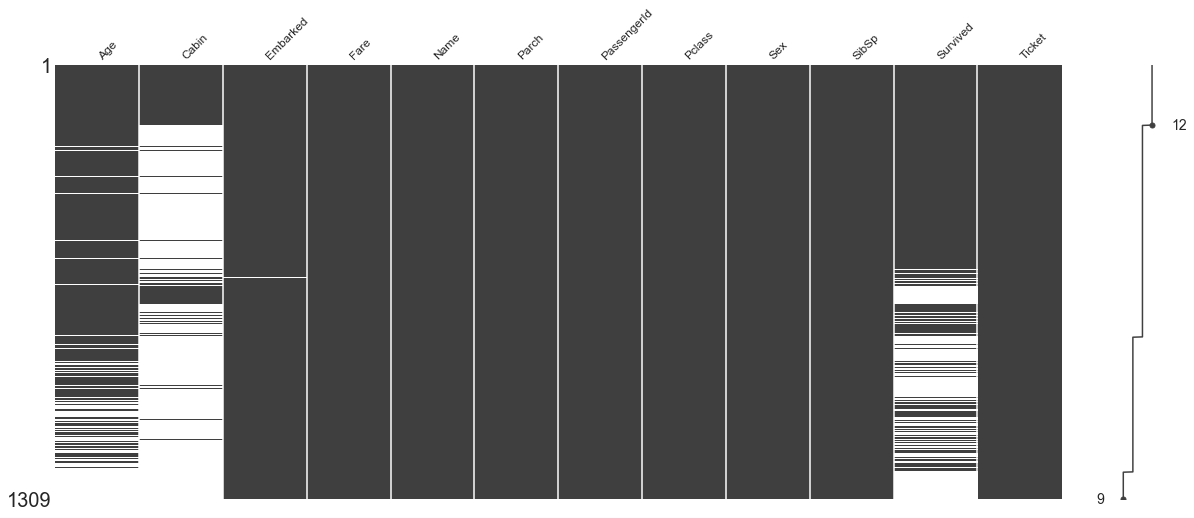

In [11]:
sorted_data = msno.nullity_sort(dataset, sort='descending')               # or sort='ascending'
msno.matrix(sorted_data,figsize=(20,8),fontsize=12)                       # Matrix de NaN

<b>Cleaning AGE column

In [12]:
# Extract Title string
dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [13]:
# Value Counts to identify significant Titles
dataset.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Don           1
Mme           1
Sir           1
Lady          1
Capt          1
Jonkheer      1
Countess      1
Dona          1
Name: Title, dtype: int64

In [14]:
# Mapping Tittle
title_dict = {'Mr':1, 'Mrs':2, 'Miss':3}       # others = 4
dataset['Title'] = dataset['Title'].map(lambda x: title_dict[x] if x in title_dict.keys() else '4')

In [15]:
# fill missing age with median age for each title (Mr, Mrs, Miss, Others)
dataset['Age'].fillna(dataset.groupby('Title')['Age'].transform('median'), inplace=True)

<b>Cleaning EMBARKED column

In [16]:
dataset[dataset.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,3
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,2


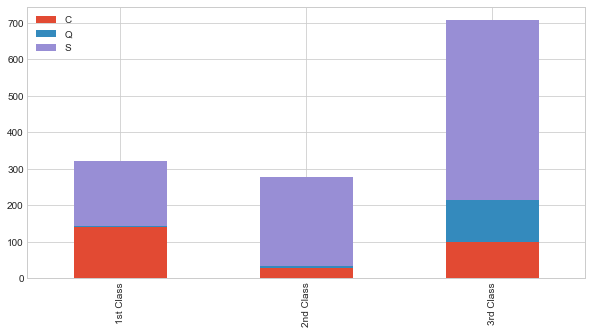

In [17]:
stacked_bar_per_class('Embarked')

In [18]:
# Filling with 'S' as max in 1s Class 
dataset['Embarked'].fillna('S', inplace=True)

<b>Cleaning CABIN column

In [19]:
dataset['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

In [20]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

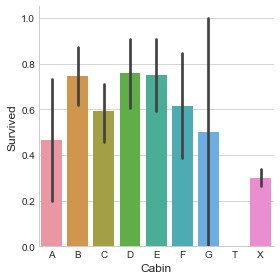

In [21]:
sns.factorplot(y="Survived", x="Cabin", data=dataset, kind="bar", order=['A','B','C','D','E','F','G','T','X'])

In [22]:
dataset['Cabin'].value_counts(dropna=False)

X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [23]:
# Tentar uma classificação das Cabines usando Ticker e Pclass
pivot = dataset[['Ticket', 'Cabin']]
pivot['Value'] = 1
pivot.pivot_table(index='Ticket', columns='Cabin', values='Value').sort_index()

Cabin,A,B,C,D,E,F,G,T,X
Ticket,,,,,,,,,
110152,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110413,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
110465,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
110469,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
110489,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
110564,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
110813,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
111163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
111240,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
dataset.isnull().sum()

Age              0
Cabin            0
Embarked         0
Fare             1
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
Title            0
dtype: int64

<b>Cleaning FARE

In [25]:
dataset[dataset['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
1043,60.5,X,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,1


In [26]:
ts = dataset[(dataset.Embarked == 'S') & (dataset.Pclass == 3) & 
             (dataset.Sex == 'male') & (dataset.Age >= 40) & (dataset.SibSp == 0)]
ts['Fare'].min(), ts['Fare'].mean(), ts['Fare'].median(), ts['Fare'].max()

(0.0, 8.22014, 7.8958, 16.100000000000001)

In [27]:
ts.sort_values(['Age'])

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
561,40.0,X,S,7.8958,"Sivic, Mr. Husein",0,562,3,male,0,0.0,349251,1
1119,40.5,X,S,15.1000,"Everett, Mr. Thomas James",0,1120,3,male,0,NaN,C.A. 6212,1
153,40.5,X,S,14.5000,"van Billiard, Mr. Austin Blyler",2,154,3,male,0,0.0,A/5. 851,1
761,41.0,X,S,7.1250,"Nirva, Mr. Iisakki Antino Aijo",0,762,3,male,0,0.0,SOTON/O2 3101272,1
933,41.0,X,S,7.8500,"Goldsmith, Mr. Nathan",0,934,3,male,0,NaN,SOTON/O.Q. 3101263,1
349,42.0,X,S,8.6625,"Dimic, Mr. Jovan",0,350,3,male,0,0.0,315088,1
845,42.0,X,S,7.5500,"Abbing, Mr. Anthony",0,846,3,male,0,0.0,C.A. 5547,1
197,42.0,X,S,8.4042,"Olsen, Mr. Karl Siegwart Andreas",1,198,3,male,0,0.0,4579,1
699,42.0,F,S,7.6500,"Humblen, Mr. Adolf Mathias Nicolai Olsen",0,700,3,male,0,0.0,348121,1
818,43.0,X,S,6.4500,"Holm, Mr. John Fredrik Alexander",0,819,3,male,0,0.0,C 7075,1


In [28]:
idx = list(dataset[dataset['Fare'].isnull()].index)

In [29]:
dataset['Fare'].iloc[idx] = ts['Fare'].median()

In [30]:
# Final check for NaNs
dataset.isnull().sum()

Age              0
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
Title            0
dtype: int64

<h2> Data Analysis

In [31]:
# delete PassengerId, Name, Ticket, Title
dataset.drop('PassengerId', axis=1, inplace=True)
dataset.drop('Name', axis=1, inplace=True)
dataset.drop('Ticket', axis=1, inplace=True)
dataset.drop('Title', axis=1, inplace=True)
dataset.shape

(1309, 9)

In [32]:
# Generate categories
dataset = pd.get_dummies(dataset, columns=['Pclass', 'Sex', 'Cabin', 'Embarked'], drop_first=True)            # get_dummies()
dataset.shape

(1309, 18)

In [33]:
get_meta(dataset)

,dtype,count,unique,mean,median,qtd_Null,variac,exemp
column,,,,,,,,
Age,float64,1309,99,29.418006,29.0000,0,79.8300,"[22.0, 38.0, 26.0, 35.0, 29.0, 54.0, 2.0, 27.0..."
Fare,float64,1309,281,33.276075,14.4542,0,512.3292,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51...."
Parch,int64,1309,8,0.385027,0.0000,0,9.0000,"[0, 1, 2, 5, 3, 4, 6, 9]"
SibSp,int64,1309,7,0.498854,0.0000,0,8.0000,"[1, 0, 3, 4, 2, 5, 8]"
Survived,float64,891,2,0.383838,0.0000,418,1.0000,"[0.0, 1.0, nan]"
Pclass_2,uint8,1309,2,0.211612,0.0000,0,1.0000,"[0, 1]"
Pclass_3,uint8,1309,2,0.541635,1.0000,0,1.0000,"[1, 0]"
Sex_male,uint8,1309,2,0.644003,1.0000,0,1.0000,"[1, 0]"
Cabin_B,uint8,1309,2,0.049656,0.0000,0,1.0000,"[0, 1]"


Age         AxesSubplot(0.125,0.125;0.168478x0.755)
Fare     AxesSubplot(0.327174,0.125;0.168478x0.755)
Parch    AxesSubplot(0.529348,0.125;0.168478x0.755)
SibSp    AxesSubplot(0.731522,0.125;0.168478x0.755)
dtype: object

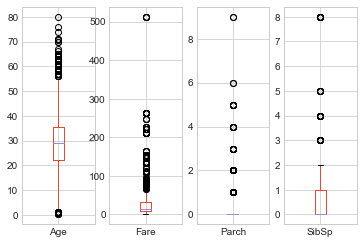

In [34]:
## Finding Outliers
dataset[['Age', 'Fare', 'Parch', 'SibSp']].plot(kind='box', subplots=True)

(<matplotlib.axes._subplots.AxesSubplot at 0x161572e7e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x161572e7e10>)

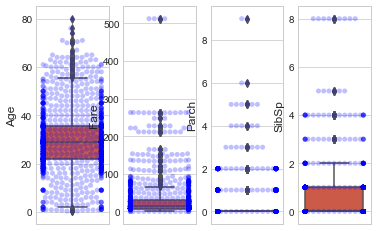

In [35]:
# Boxplot to identify Outliers
# Demora devido ao swarmplot
fig, ax = plt.subplots(1,4)
sns.boxplot(dataset['Age'], orient="v", ax=ax[0]), sns.swarmplot(dataset['Age'], orient="v", color='b', alpha=".25", ax=ax[0])
sns.boxplot(dataset['Fare'], orient="v", ax=ax[1]), sns.swarmplot(dataset['Fare'], orient="v", color='b', alpha=".25", ax=ax[1])
sns.boxplot(dataset['Parch'], orient="v", ax=ax[2]), sns.swarmplot(dataset['Parch'], orient="v", color='b', alpha=".25",ax=ax[2])
sns.boxplot(dataset['SibSp'], orient="v", ax=ax[3]), sns.swarmplot(dataset['SibSp'], orient="v", color='b', alpha=".25",ax=ax[3])

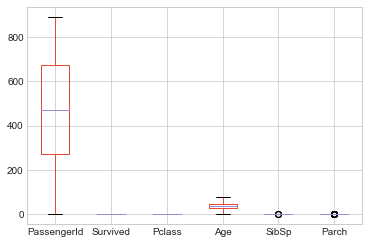

In [36]:
train.loc[train['Pclass'] == 1].plot( x='Fare', kind='box')

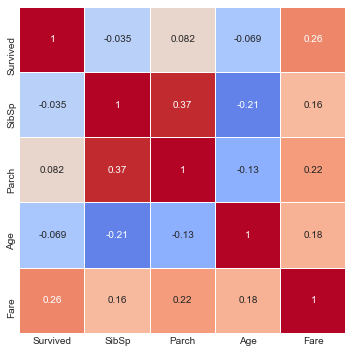

In [37]:
plt.figure(figsize=(6,6))
sns.heatmap(dataset[["Survived","SibSp","Parch","Age","Fare"]].corr(), 
            vmax=0.4, vmin=-0.3, square=True, annot=True, cmap = "coolwarm", linewidths=0.1, linecolor='white', cbar=False)

In [38]:
# Create a Family Size from SibSp and Parch sum
dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
dataset.drop(labels=['SibSp', 'Parch'], axis=1, inplace=True)

In [39]:
dataset.shape

(1309, 17)

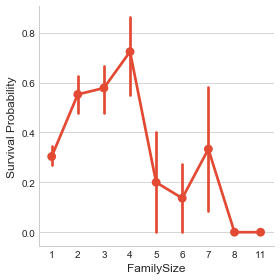

In [40]:
# Big families have lower Survival Probability
g = sns.factorplot(x="FamilySize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

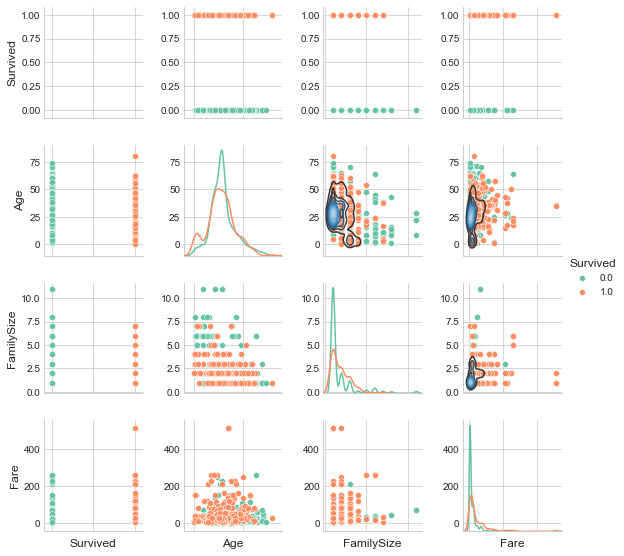

In [41]:
columns = ['Survived','Age','FamilySize','Fare']
g = sns.pairplot(data=dataset.dropna(), vars=columns, size=2, 
                 hue='Survived', palette="Set2", diag_kind="kde").map_upper(sns.kdeplot, cmap="Blues_d")
g.set(xticklabels=[])

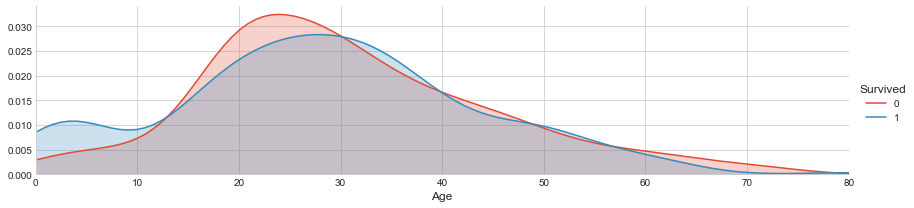

In [42]:
# Survived per AGE - Train
facet = sns.FacetGrid(train, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

In [43]:
surv   = train[train['Survived']==1]
nosurv = train[train['Survived']==0]

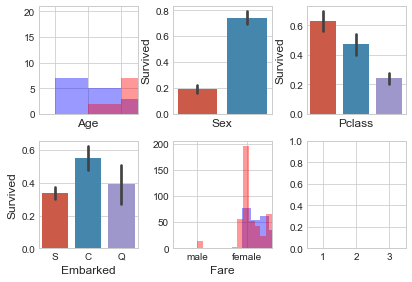

In [44]:
fig, ax = plt.subplots(2, 3, sharex='col')
sns.distplot(surv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color='b', ax=ax[0,0])
sns.distplot(nosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color='r', axlabel='Age', ax=ax[0,0])
sns.barplot('Sex', 'Survived', data=train, ax=ax[0,1])
sns.barplot('Pclass', 'Survived', data=train, ax=ax[0,2])
sns.barplot('Embarked', 'Survived', data=train, ax=ax[1,0])
#sns.barplot('FamilySize', 'Survived', data=train, ax=ax[1,1])
sns.distplot(np.log10(surv['Fare'].dropna().values+1), kde=False, color='b', ax=ax[1,1])
sns.distplot(np.log10(nosurv['Fare'].dropna().values+1), kde=False, color='r', axlabel='Fare', ax=ax[1,1])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

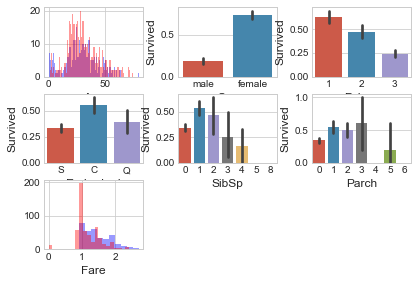

In [45]:
plt.subplot(331), sns.distplot(surv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color='b')
sns.distplot(nosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color='r', axlabel='Age')
plt.subplot(332), sns.barplot('Sex', 'Survived', data=train)
plt.subplot(333), sns.barplot('Pclass', 'Survived', data=train)
plt.subplot(334), sns.barplot('Embarked', 'Survived', data=train)
plt.subplot(335), sns.barplot('SibSp', 'Survived', data=train)
plt.subplot(336), sns.barplot('Parch', 'Survived', data=train)
plt.subplot(337), sns.distplot(np.log10(surv['Fare'].dropna().values+1), kde=False, color='b')
sns.distplot(np.log10(nosurv['Fare'].dropna().values+1), kde=False, color='r', axlabel='Fare')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

<b>Normalizing

In [46]:
def Do_Scale(train, test, scale):       #Normalizer(), MaxAbsScaler(), MinMaxScaler(), KernelCenterer(), and StandardScaler()
    if scale == 'Normalizer':
        from sklearn.preprocessing import Normalizer
        scaler = Normalizer()
    elif scale == 'StandardScaler':
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
    elif scale == 'MaxAbsScaler':
        from sklearn.preprocessing import MaxAbsScaler
        scaler = MaxAbsScaler()
    elif scale == 'MinMaxScaler':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
    elif scale == 'KernelCenterer':
        from sklearn.preprocessing import KernelCenterer
        scaler = KernelCenterer()
    else:
        return train, test
    d1 = scaler.fit_transform(train)
    d2 = scaler.fit_transform(test)
    return d1, d2

In [ ]:
#Normalizer, StandardScaler, MaxAbsScaler, MinMaxScaler or KernelCenterer
scaler = 'KernelCenterer'
X_trainS, X_testS = Do_Scale(X_train, X_test, scaler)

<h2>Model

In [48]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [49]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, cross_val_score
from sklearn.metrics import roc_auc_score

In [50]:
## Separate train dataset and test dataset
X_train = dataset[:train_len]
X_test = dataset[train_len:]
X_test.drop(labels=["Survived"],axis = 1,inplace=True)
assert train_size == len(X_train)        # check the sizes
assert test_size == len(X_test)    # check the sizes

In [51]:
## Train variables
y_train = X_train.Survived
X_train = X_train.drop(['Survived'], axis=1)

<b>Cross Validation - No leak

In [52]:
# Generate K folds
n_splits=5
kfolds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [53]:
## Cross Validation with Holdout - Import K folds
def cross_val_model_holdout(X, y, model, kfolds, scoring = "accuracy", n_jobs=-1):
    X = np.array(X)
    y = np.array(y)
    folds = kfolds.split(X, y)
    
    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]
        
        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)        
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=kfolds, scoring='accuracy')
        print("    cross_score: %.5f" % cross_score.mean())

In [54]:
## Cross Validation without Holdout - Import K folds
def cross_val_model(X, y, model, kfolds, scoring = 'accuracy', n_jobs=-1):
    X = np.array(X)
    y = np.array(y)
  
    cross_score = cross_val_score(model, X, y, cv=kfolds, scoring=scoring, n_jobs=n_jobs)
    print('------------------------------')
    print('%s: ' % (str(model).split('(')[0]))
    for k in range(kfolds.n_splits):
        print('Fold ' + str(k+1) + ' : ' + str(cross_score[k]))
    print('Cross_score: %.5f' % cross_score.mean())
    return cross_score

In [55]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
models = [
    SVC(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1),
    RandomForestClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    MLPClassifier(random_state=random_state),
    KNeighborsClassifier(),
    LogisticRegression(random_state = random_state),
    LinearDiscriminantAnalysis(),
    XGBClassifier(seed=random_state),
    LGBMClassifier(seed=random_state)
]
for m in models:
    classifiers.append(m)

------------------------------
SVC: 
Fold 1 : 0.720670391061
Fold 2 : 0.703910614525
Fold 3 : 0.73595505618
Fold 4 : 0.769662921348
Fold 5 : 0.700564971751
Cross_score: 0.72615
------------------------------
DecisionTreeClassifier: 
Fold 1 : 0.776536312849
Fold 2 : 0.776536312849
Fold 3 : 0.752808988764
Fold 4 : 0.825842696629
Fold 5 : 0.80790960452
Cross_score: 0.78793
------------------------------
AdaBoostClassifier: 
Fold 1 : 0.787709497207
Fold 2 : 0.782122905028
Fold 3 : 0.73595505618
Fold 4 : 0.859550561798
Fold 5 : 0.796610169492
Cross_score: 0.79239
------------------------------
RandomForestClassifier: 
Fold 1 : 0.798882681564
Fold 2 : 0.782122905028
Fold 3 : 0.814606741573
Fold 4 : 0.837078651685
Fold 5 : 0.796610169492
Cross_score: 0.80586
------------------------------
ExtraTreesClassifier: 
Fold 1 : 0.804469273743
Fold 2 : 0.776536312849
Fold 3 : 0.775280898876
Fold 4 : 0.842696629213
Fold 5 : 0.762711864407
Cross_score: 0.79234
------------------------------
GradientBoos

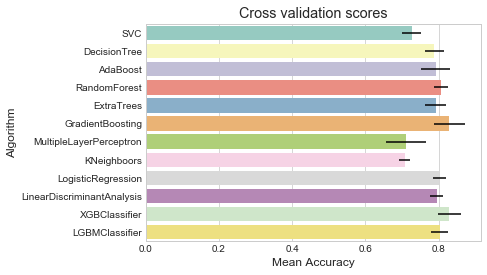

In [56]:
# Cross Valuation results
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_model(model = classifier,
                                      X = X_train,
                                      y = y_train, 
                                      scoring = "accuracy",       # or "roc_auc"
                                      kfolds = kfolds,            # Number of Folds
                                      n_jobs=-1))                 # default = -1 all CPUs
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
cv_res = pd.DataFrame({"CrossValMeans":cv_means,
                       "CrossValerrors": cv_std,
                       "Algorithm":["SVC",
                                    "DecisionTree",
                                    "AdaBoost",
                                    "RandomForest",
                                    "ExtraTrees",
                                    "GradientBoosting",
                                    "MultipleLayerPerceptron",
                                    "KNeighboors",
                                    "LogisticRegression",
                                    "LinearDiscriminantAnalysis",
                                    "XGBClassifier",
                                    "LGBMClassifier"]})
# Plotting Results
g = sns.barplot("CrossValMeans", "Algorithm", data = cv_res, palette="Set3", orient = "h", **{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

<b>Hyperparameter tunning for best models

In [57]:
# Variáveis
scoring     = "accuracy"
n_jobs      = 4
verbose     = 1
model       = ''
model_name  = str(model).split('(')[0]

In [58]:
# XGBoost Parameters tunning
model = XGBClassifier()
s     = time.time()

## Search grid for optimal parameters
xgb_param_grid = {'n_estimators'    : [250, 500, 750],
                  'learning_rate'   : [0.1, 0.05, 0.01],
                  'max_depth'       : [4, 6, 8],
                  'colsample_bytree': [0.8, 0.9, 1.0],
                  'subsample'       : [0.5, 0.75, 1.0],
                  'seed'            : [42]}

gsXGB = GridSearchCV(model, param_grid = xgb_param_grid, cv=kfolds, scoring=scoring, n_jobs=n_jobs , verbose=verbose)
gsXGB.fit(X_train, y_train)
XGB_best = gsXGB.best_estimator_
print("Tunning "+ str(model_name) +" completed in: "+ str(time.time()-s) +" s")   # Model Name and timing
print('Best score: ', gsXGB.best_score_)                                         # Best score
print('Best parameters: ', gsXGB.best_params_)                                   # Best parameters

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   46.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1215 out of 1215 | elapsed:  2.3min finished


Tunning  completed in: 141.71851921081543 s
Best score:  0.847362514029
Best parameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 750, 'seed': 42, 'subsample': 1.0}


In [59]:
# GradientBoostingClassifier Parameters tunning
model = GradientBoostingClassifier()
s     = time.time()

## Search grid for optimal parameters
gb_param_grid = {'n_estimators'    : [100, 500, 1000, 1500],
                 'learning_rate'   : [0.1, 0.05, 0.01],
                 'max_depth'       : [2, 4, 6, 8],
                 'min_samples_leaf': [100, 150],
                 'max_features'    : [0.3, 0.1],
                 'random_state'    : [42]}

gsGBC = GridSearchCV(model, param_grid=gb_param_grid, cv=kfolds, scoring=scoring, n_jobs=n_jobs , verbose=verbose)
gsGBC.fit(X_train, y_train)
GBC_best = gsGBC.best_estimator_
print("Tunning "+ str(model_name) +" completed in: "+ str(time.time()-s) +" s")   # Model Name and timing
print('Best score: ', gsGBC.best_score_)                                         # Best score
print('Best parameters: ', gsGBC.best_params_)                                   # Best parameters

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   42.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 960 out of 960 | elapsed:  1.5min finished


Tunning  completed in: 89.53672003746033 s
Best score:  0.822671156004
Best parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 100, 'n_estimators': 1000, 'random_state': 42}


In [60]:
# LogisticRegression Parameters tunning
model = LogisticRegression()
s     = time.time()

## Search grid for optimal parameters
lr_param_grid = {'C'           : [0.1, 0.5, 1, 5, 10, 50, 100],
                 'solver'      : ['liblinear', 'saga'],
                 'penalty'     : ['l1', 'l2'],
                 'random_state': [42]}

gsLR = GridSearchCV(model, param_grid=lr_param_grid, cv=kfolds, scoring=scoring, n_jobs=n_jobs , verbose=verbose)
gsLR.fit(X_train, y_train)
LR_best = gsLR.best_estimator_
print("Tunning "+ str(model_name) +" completed in: "+ str(time.time()-s) +" s")   # Model Name and timing
print('Best score: ', gsLR.best_score_)                                          # Best score
print('Best parameters: ', gsLR.best_params_)                                    # Best parameters

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Tunning  completed in: 4.154771089553833 s
Best score:  0.808080808081
Best parameters:  {'C': 5, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}


[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    3.9s finished


In [61]:
# LinearDiscriminantAnalysis Parameters tunning
model = LinearDiscriminantAnalysis()
s     = time.time()

## Search grid for optimal parameters
lda_param_grid = {'solver'       : ['svd', 'lsqr'],
                  'n_components' : [2, 10]}

gsLDA = GridSearchCV(model, param_grid = lda_param_grid, cv=kfolds, scoring=scoring, n_jobs=n_jobs , verbose=verbose)
gsLDA.fit(X_train, y_train)
LDA_best = gsLDA.best_estimator_
print("Tunning "+ str(model_name) +" completed in: "+ str(time.time()-s) +" s")   # Model Name and timing
print('Best score: ', gsLDA.best_score_)                                         # Best score
print('Best parameters: ', gsLDA.best_params_)                                   # Best parameters

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Tunning  completed in: 3.367957830429077 s
Best score:  0.794612794613
Best parameters:  {'n_components': 2, 'solver': 'svd'}


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    3.1s finished


In [62]:
# LightGBM Parameters tunning
model = LGBMClassifier()
s     = time.time()

## Search grid for optimal parameters
lgbm_param_grid = {'n_estimators'     : [250, 500, 750],
                   'learning_rate'    : [0.01, 0.05, 0.1],
                   'max_depth'        : [4, 6, 8],
                   'subsample'        : [0.5, 0.75, 1.0],
                   'colsample_bytree' : [0.8, 0.9, 1.0],
                   'seed'             : [42]}

gsLGBM = GridSearchCV(model, param_grid= lgbm_param_grid, cv=kfolds, scoring=scoring, n_jobs=n_jobs , verbose=verbose)
gsLGBM.fit(X_train, y_train)
LGBM_best = gsLGBM.best_estimator_
print("Tunning "+ str(model_name) +" completed in: "+ str(time.time()-s) +" s")   # Model Name and timing
print('Best score: ', gsLGBM.best_score_)                                        # Best score
print('Best parameters: ', gsLGBM.best_params_)                                  # Best parameters

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 1215 out of 1215 | elapsed:  3.0min finished


Tunning  completed in: 182.96619868278503 s
Best score:  0.848484848485
Best parameters:  {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'seed': 42, 'subsample': 0.75}


In [63]:
# RandomForestClassifier Parameters tunning
model = RandomForestClassifier()
s     = time.time()

## Search grid for optimal parameters
rf_param_grid = {'n_estimators'      : [100, 300],
                 'max_depth'         : [None],
                 'max_features'      : ['auto', None, 'sqrt', 'log2', 1, 3, 7],
                 'min_samples_split' : [2, 3, 10],
                 'min_samples_leaf'  : [3, 5, 10],
                 'oob_score'         : [False, True],                 
                 'criterion'         : ["gini"],
                 'random_state'      : [42]}

gsRFC = GridSearchCV(model, param_grid= rf_param_grid, cv=kfolds, scoring=scoring, n_jobs=n_jobs , verbose=verbose)
gsRFC.fit(X_train, y_train)
RFC_best = gsRFC.best_estimator_
print("Tunning "+ str(model_name) +" completed in: "+ str(time.time()-s) +" s")   # Model Name and timing
print('Best score: ', gsRFC.best_score_)                                         # Best score
print('Best parameters: ', gsRFC.best_params_)                                   # Best parameters

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   55.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 1260 out of 1260 | elapsed:  2.3min finished


Tunning  completed in: 138.00106525421143 s
Best score:  0.83950617284
Best parameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300, 'oob_score': False, 'random_state': 42}


In [ ]:
########  try fit_params in RandomizedSearchCV

<b>Selected Models

In [64]:
model_list = [("LightGBM",                     LGBM_best),
              ("XGBoost",                      XGB_best),
              ("RandomForest",                 RFC_best),
              ("GradientBoosting",             GBC_best),
              ("LogisticRegression",           LR_best),
              ("LinearDiscriminantAnalysis",   LDA_best)]

<b>Plot learning curves</b><br>
Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

In [65]:
def multi_learning_curve(models, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    nrows = int(np.ceil(len(models)/2))
    ncols = 2
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))
    nclassifier = 0
    for row in range(nrows):
        for col in range(ncols): 
            name = models[nclassifier][0]
            classifier = models[nclassifier][1]
            title = name +" learning curves"
            """Generate a simple plot of the test and training learning curve"""
            plt.figure()
            axes[row, col].set_title(title)
            if ylim is not None:
                plt.ylim(*ylim)
            axes[row, col].set_xlabel("Training examples")
            axes[row, col].set_ylabel("Score")
            train_sizes, train_scores, test_scores = learning_curve(classifier, X, y,
                                                                    cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)
            axes[row, col].grid()
            axes[row, col].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
            axes[row, col].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
            axes[row, col].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
            axes[row, col].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
            axes[row, col].legend(loc="best");
            nclassifier += 1

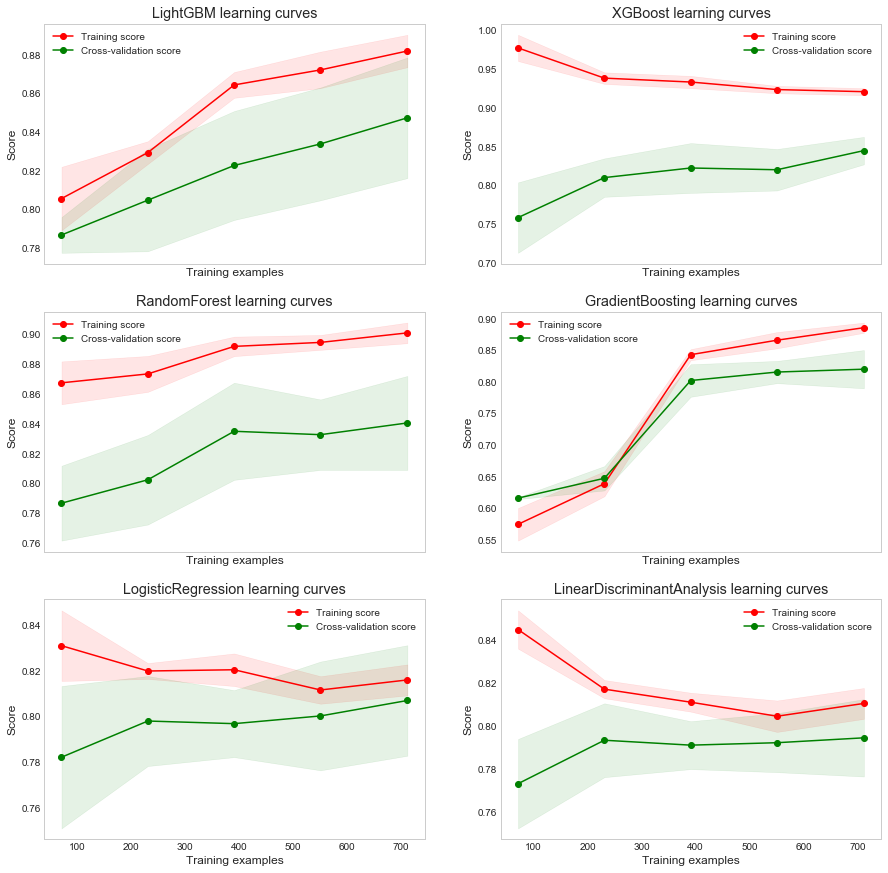

In [66]:
multi_learning_curve(models= model_list, X= X_train, y= y_train, cv= kfolds)

<b>Feature Importance

In [67]:
model_list = [("LightGBM",        LGBM_best),
              ("XGBoost",         XGB_best),
              ("RandomForest",    RFC_best),
              ("GradientBoosting",GBC_best)]

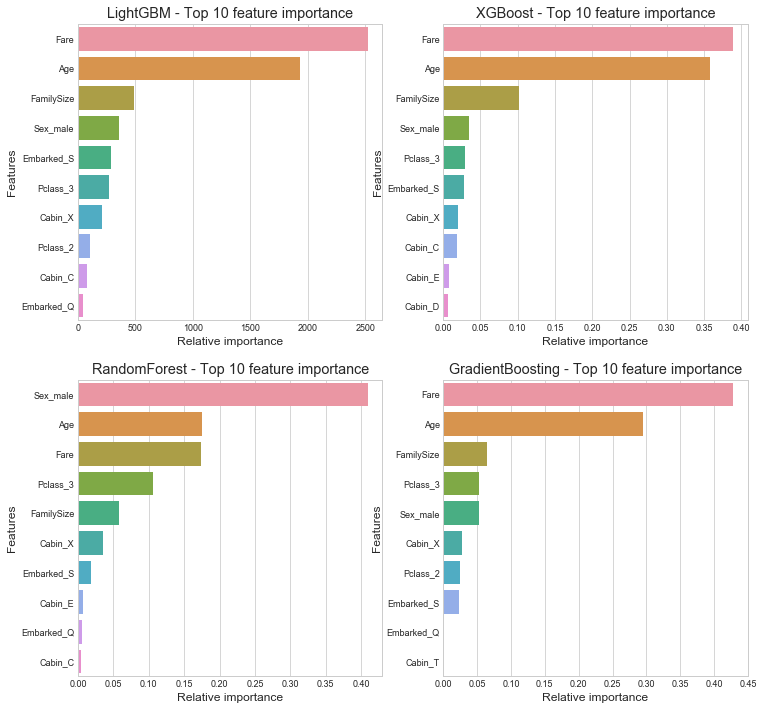

In [68]:
# PLot Feature Importance
top = 10
nrows =  int(np.ceil(len(model_list)/2))
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(12,12))
nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = model_list[nclassifier][0]
        classifier = model_list[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:top]
        sns.barplot(y = X_train.columns[indices][:top],
                        x = classifier.feature_importances_[indices][:top], orient='h', ax=axes[row][col])
        axes[row,col].set_xlabel("Relative importance",fontsize=12)
        axes[row,col].set_ylabel("Features",fontsize=12)
        axes[row,col].tick_params(labelsize=9)
        axes[row,col].set_title(name + " - Top "+str(top)+" feature importance")
        nclassifier += 1

<h3>Ensemble modeling

In [69]:
# Predict Test
Predict_RFC  = pd.Series(RFC_best.predict(X_test),  name="RFC")
Predict_LGBM = pd.Series(LGBM_best.predict(X_test), name="LGBM")
Predict_XGB  = pd.Series(XGB_best.predict(X_test),  name="XGB")
Predict_GBC  = pd.Series(GBC_best.predict(X_test),  name="GBC")

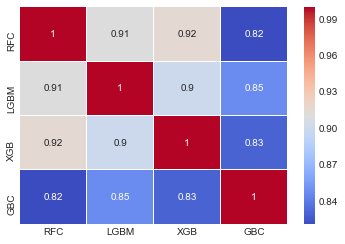

In [70]:
# Concatenate all classifier results
ensemble_results = pd.concat([Predict_RFC, Predict_LGBM, Predict_XGB, Predict_GBC],axis=1)
g= sns.heatmap(ensemble_results.corr(), annot=True, cmap = "coolwarm", linewidths=0.1)

In [71]:
votingC = VotingClassifier(estimators= model_list, voting='hard', n_jobs=4)
votingC = votingC.fit(X_train, y_train)
votingC

VotingClassifier(estimators=[('LightGBM', LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, learning_rate=0.01,
        max_bin=255, max_depth=6, min_child_samples=10, min_child_weight=5,
        min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
        objective=None, random_state=0, reg_alph...        presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=4, voting='hard', weights=None)

In [72]:
# Predict results
y_target = pd.Series(votingC.predict(X_test), name="Survived")

<b>Submission

In [73]:
y_target = y_target.astype(int)
results = pd.concat([id_test, y_target], axis=1)
results.columns = ['PassengerId','Survived']
results.to_csv("Titanic_submit.csv", index=False)

In [ ]:
# submit = pd.DataFrame({'PassengerId' : test.loc[:,'PassengerId'], 'Survived': y_pred.T})                       
# submit.to_csv("submit.csv", index=False)

In [ ]:
######### DRAFTS #############

In [ ]:
def drawPredictions(X_train, X_test, y_train, y_test):
    fig = plt.figure()
    fig.set_tight_layout(True)
    
    # Make some guesses
    y_guess = model.predict(X_test)

    # INFO: This is the second lab we're demonstrating how to
    # do multi-plots using matplot lab. In the next assignment(s),
    # it'll be your responsibility to use this and assignment #1
    # as tutorials to add in the plotting code yourself!
    num_rows = 10
    num_cols = 5

    index = 0
    for col in range(num_cols):
        for row in range(num_rows):
            plt.subplot(num_cols, num_rows, index + 1)

            # 8x8 is the size of the image, 64 pixels
            plt.imshow(X_test.ix[index,:].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')

            # Green = Guessed right
            # Red = Fail!
            fontcolor = 'g' if y_test[index] == y_guess[index] else 'r'
            plt.title('Label: %i' % y_guess[index], fontsize=6, color=fontcolor)
            plt.axis('off')
            index += 1
    plt.show()

In [ ]:
def drawPlots(model, X_train, X_test, y_train, y_test, wintitle='Figure 1'):
    # You can use this to break any higher-dimensional space down,
    # And view cross sections of it.

    # If this line throws an error, use plt.style.use('ggplot') instead
    mpl.style.use('ggplot') # Look Pretty

    padding = 3
    resolution = 0.5
    max_2d_score = 0

    y_colors = ['#ff0000', '#00ff00', '#0000ff']
    my_cmap  = mpl.colors.ListedColormap(['#ffaaaa', '#aaffaa', '#aaaaff'])
    colors   = [y_colors[i] for i in y_train]
    num_columns = len(X_train.columns)

    fig = plt.figure()
    fig.canvas.set_window_title(wintitle)
    fig.set_tight_layout(True)
    
    cnt = 0
    for col in range(num_columns):
        for row in range(num_columns):
            
            # Easy out
            if FAST_DRAW and col > row:
                cnt += 1
                continue

            ax = plt.subplot(num_columns, num_columns, cnt + 1)
            plt.xticks(())
            plt.yticks(())

            # Intersection:
            if col == row:
                plt.text(0.5, 0.5, X_train.columns[row], verticalalignment='center', horizontalalignment='center', fontsize=12)
                cnt += 1
                continue


            # Only select two features to display, then train the model
            X_train_bag = X_train.ix[:, [row,col]]
            X_test_bag = X_test.ix[:, [row,col]]
            model.fit(X_train_bag, y_train)

            # Create a mesh to plot in
            x_min, x_max = X_train_bag.ix[:, 0].min() - padding, X_train_bag.ix[:, 0].max() + padding
            y_min, y_max = X_train_bag.ix[:, 1].min() - padding, X_train_bag.ix[:, 1].max() + padding
            xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                                 np.arange(y_min, y_max, resolution))

            # Plot Boundaries
            plt.xlim(xx.min(), xx.max())
            plt.ylim(yy.min(), yy.max())

            # Prepare the contour
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contourf(xx, yy, Z, cmap=my_cmap, alpha=0.8)
            plt.scatter(X_train_bag.ix[:, 0], X_train_bag.ix[:, 1], c=colors, alpha=0.5)


            score = round(model.score(X_test_bag, y_test) * 100, 3)
            plt.text(0.5, 0, "Score: {0}".format(score), transform = ax.transAxes, horizontalalignment='center', fontsize=8)
            max_2d_score = score if score > max_2d_score else max_2d_score

            cnt += 1

    print("Max 2D Score: ", max_2d_score)